# Import Library
mengimpor library python yang digunakan untuk menganalisis dan membangun model machine learning

In [246]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Loading Dataset

karena saya ingin memprediksi harga saham pada BBCA jadi saya perlu untuk mengimpor datasetnya terlebih dahulu. dataset yang saya gunakan ini berasal dari yahoo finance. saya lakukan head(), describe(), dan info() untuk mengetahui nilai dan informasi yang terdapat pada dataset tersebut. saya menampilkan heatmap untuk melihat kolerasi antar kolom yang terdapat pada dataset. saya menampilkan grafik agar terlihat pergerakan harga sahamnya

In [247]:
# Ambil data saham BBCA dari Yahoo Finance
df = yf.download("BBCA.JK", start="2018-01-01", end="2025-5-29")

# Lihat 5 baris pertama
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
Date,,,,,
2018-01-01,3723.926270,3723.926270,3723.926270,3723.926270,0
2018-01-02,3723.926270,3830.202704,3711.173097,3723.926270,82303500
2018-01-03,3723.926270,3732.428384,3626.151950,3728.177327,68214000
2018-01-04,3779.190186,3779.190186,3723.926437,3723.926437,76567000
2018-01-05,3783.440918,3808.947261,3770.687746,3791.943032,65268000


In [248]:
# Statistik deskriptif
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
count,1821.000000,1821.000000,1821.000000,1821.000000,1.821000e+03
mean,6591.288824,6650.912816,6532.491071,6592.331391,8.326811e+07
std,1898.744264,1911.897291,1887.138078,1898.273948,5.535698e+07
min,3529.552490,3606.654738,3529.552490,3589.520949,0.000000e+00
25%,5067.398926,5117.358979,5014.290956,5062.974016,5.416800e+07
50%,6059.347656,6170.324063,6028.274263,6103.737932,7.255150e+07
75%,8343.284180,8428.511929,8300.000000,8358.078334,9.824950e+07
max,10570.414062,10570.414062,10401.480469,10522.147296,7.564316e+08


In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1821 entries, 2018-01-01 to 2025-05-28
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BBCA.JK)   1821 non-null   float64
 1   (High, BBCA.JK)    1821 non-null   float64
 2   (Low, BBCA.JK)     1821 non-null   float64
 3   (Open, BBCA.JK)    1821 non-null   float64
 4   (Volume, BBCA.JK)  1821 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.4 KB


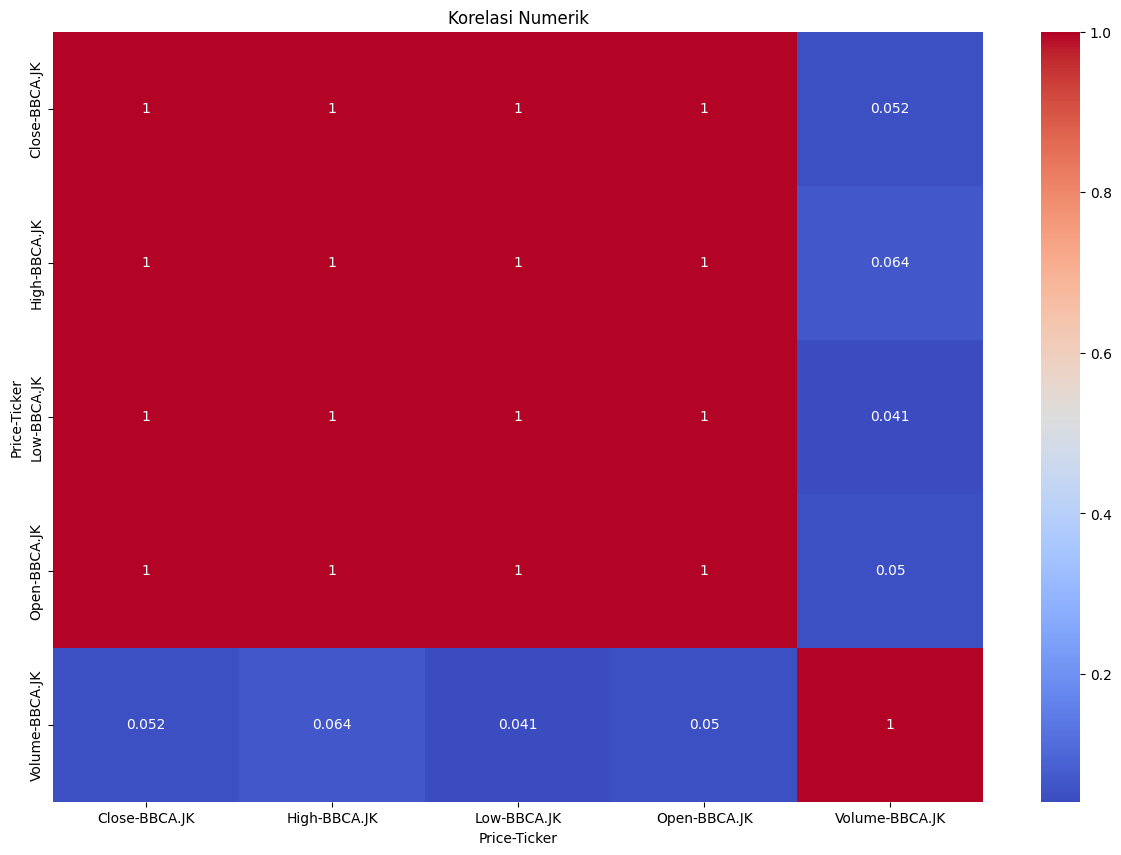

In [250]:
numerical_columns = df.select_dtypes(include=np.number)
plt.figure(figsize=(15, 10))
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Numerik')
plt.show()

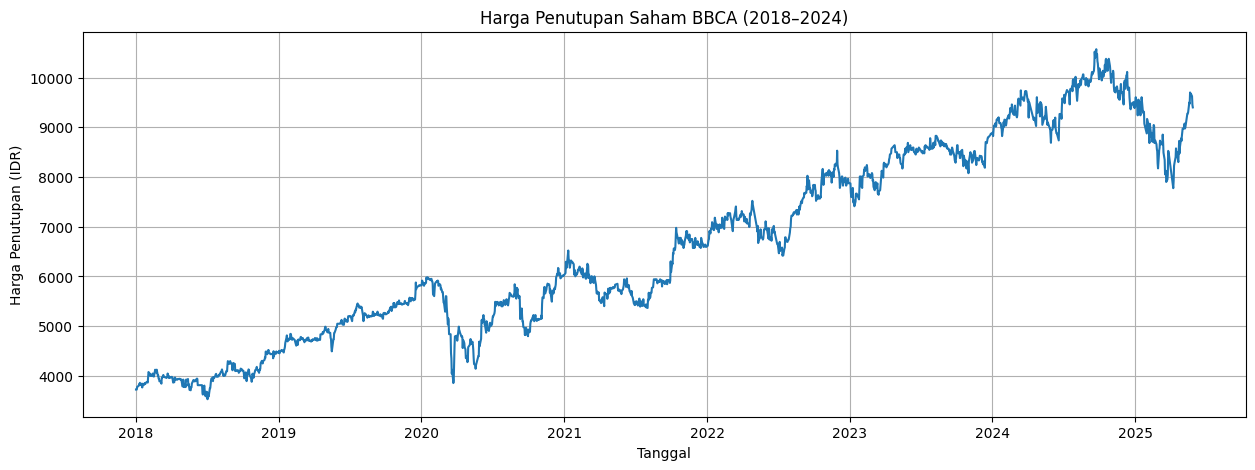

In [251]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Harga Penutupan Saham BBCA (2018–2024)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (IDR)')
plt.grid(True)
plt.show()

# Pembersihan dan Pra Pemrosesan Data

Pada tahap ini, saya akan melakukan Pembersihan Dataset untuk menjadikan dataset mudah diintepretasi dan bisa dilatih. Hal-hal yang saya lakukan yaitu:

1. Mengecek dataset menggunakan isnull().sum() dan duplicated().sum(). namun setelah saya pelajari terdapat nilai yang 0, hal itu menggambarkan dihari tersebut market sedang libur.

2. mengecek terdapat outlier atau tidak, pada dataset terdapat outlier di volume. Saya tidak melakukan drop atau yang lainnya karena volume menurut saya emang terdapat lonjakan yang cukup signifikan untuk mempengaruhi harga sahamnya.

3. membuat kolom baru untuk menambahkan MA sebagai indikator tambahan, serta memilih fitur yang akan digunakan untuk targetnya. MA merupakan rata-rata pergerakan dari masalalu jadi saya tambahkan untuk drop NA.

4. Melakukan feature scaling menggunakan MinMaxScaler() atau StandardScalar() untuk fitur numerik.

In [252]:
# pengecekan duplikat
df_clear = df.duplicated().sum()
print(df_clear)

19


In [253]:
# Menghilangkan duplikat
df.drop_duplicates(inplace=True)

In [254]:
df_clear = df.duplicated().sum()
print(df_clear)

0


In [255]:
# pengecekan dataset menggunakan isnull().sum()
df_clear = df.isnull().sum()
print(df_clear)

Price   Ticker 
Close   BBCA.JK    0
High    BBCA.JK    0
Low     BBCA.JK    0
Open    BBCA.JK    0
Volume  BBCA.JK    0
dtype: int64


In [256]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1802 entries, 2018-01-01 to 2025-05-28
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BBCA.JK)   1802 non-null   float64
 1   (High, BBCA.JK)    1802 non-null   float64
 2   (Low, BBCA.JK)     1802 non-null   float64
 3   (Open, BBCA.JK)    1802 non-null   float64
 4   (Volume, BBCA.JK)  1802 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 84.5 KB


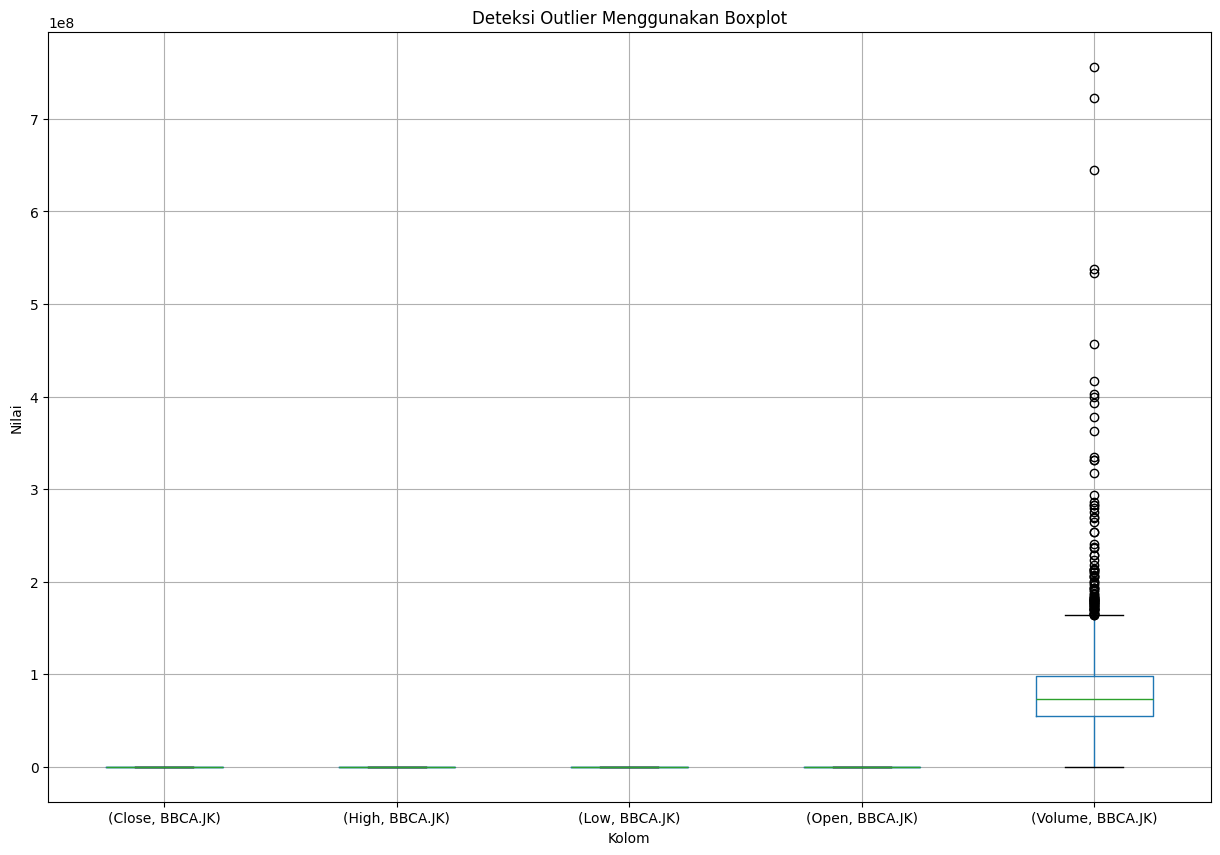

In [257]:
plt.figure(figsize=(15, 10))
df.boxplot()
plt.title('Deteksi Outlier Menggunakan Boxplot')
plt.xlabel('Kolom')
plt.ylabel('Nilai')
plt.show()

In [258]:
# pemilihan fitur
# Tambahkan fitur teknikal
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA14'] = df['Close'].rolling(window=14).mean()
df['Return'] = df['Close'].pct_change()
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA14', 'Return']]
target = df['target']

# Drop rows with NaN values that were introduced by feature engineering
# This ensures that the scaler and the models receive clean data.
df.dropna(inplace=True)

# Re-assign features and target from the DataFrame after dropping NaNs
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA14', 'Return']]
target = df['target']

In [259]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Melakukan scaling pada kolom numerik
features = scaler.fit_transform(features)

# Menampilkan DataFrame setelah scaling
print(features)

[[-1.51531188 -1.50498822 -1.49124284 ... -1.49046667 -1.50135739
   1.1959185 ]
 [-1.48145445 -1.50050466 -1.47762549 ... -1.49046667 -1.497802
  -0.39751659]
 [-1.48822589 -1.50723018 -1.47535581 ... -1.49337223 -1.494085
   0.03111241]
 ...
 [ 1.57309173  1.55745834  1.56075719 ...  1.55972955  1.44107043
  -0.37372091]
 [ 1.54654335  1.53108996  1.53406281 ...  1.57112091  1.45912808
  -1.21243314]
 [ 1.4934466   1.50472159  1.50736843 ...  1.56352667  1.47338411
  -0.38165097]]


# Membangun model

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

saya menggunakan 3 model:
- logistic regression
- random forest
- xgboost

semua model pada akhirnya saya lihat akurasinya menggunakan klasifikasi report dan juga confusion matrixnya untuk melihat seberapa baik model tersebut bekerja


In [260]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)
print(X_train.shape, X_valid.shape)

(1431, 8) (358, 8)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.95      0.71       197
           1       0.61      0.09      0.15       161

    accuracy                           0.56       358
   macro avg       0.58      0.52      0.43       358
weighted avg       0.58      0.56      0.46       358



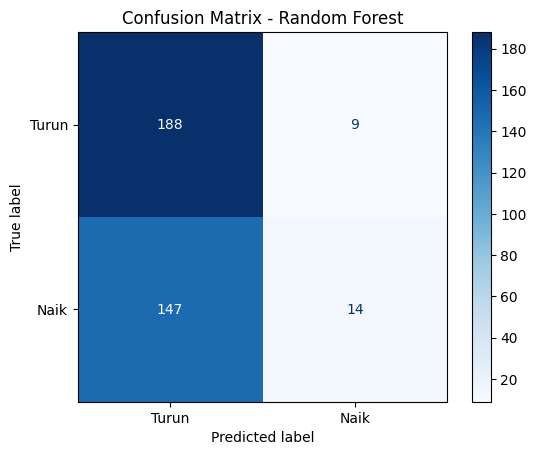

Random Forest Accuracy: 0.5642458100558659
Random Forest Precision: 0.6086956521739131
Random Forest Recall: 0.08695652173913043


In [261]:
# Model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, Y_train)

# Prediksi dengan Random Forest
predictions_rf = model_rf.predict(X_valid)

# Evaluasi model Random Forest
print("Random Forest Classification Report:")
print(classification_report(Y_valid, predictions_rf))

cm_rf = confusion_matrix(Y_valid, predictions_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Turun', 'Naik'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()

print("Random Forest Accuracy:", accuracy_score(Y_valid, predictions_rf))
print("Random Forest Precision:", precision_score(Y_valid, predictions_rf))
print("Random Forest Recall:", recall_score(Y_valid, predictions_rf))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.85      0.68       197
           1       0.54      0.21      0.30       161

    accuracy                           0.56       358
   macro avg       0.55      0.53      0.49       358
weighted avg       0.56      0.56      0.51       358



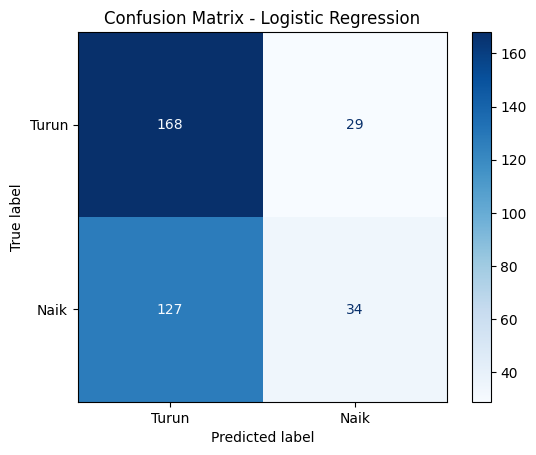

Logistic Regression Accuracy: 0.5642458100558659
Logistic Regression Precision: 0.5396825396825397
Logistic Regression Recall: 0.2111801242236025


In [262]:
# Model Logistic Regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, Y_train)

# Prediksi dengan Logistic Regression
predictions_lr = model_lr.predict(X_valid)

# Evaluasi model Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(Y_valid, predictions_lr))

cm_lr = confusion_matrix(Y_valid, predictions_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Turun', 'Naik'])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

print("Logistic Regression Accuracy:", accuracy_score(Y_valid, predictions_lr))
print("Logistic Regression Precision:", precision_score(Y_valid, predictions_lr))
print("Logistic Regression Recall:", recall_score(Y_valid, predictions_lr))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.91      0.70       197
           1       0.55      0.14      0.22       161

    accuracy                           0.56       358
   macro avg       0.56      0.52      0.46       358
weighted avg       0.56      0.56      0.48       358



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


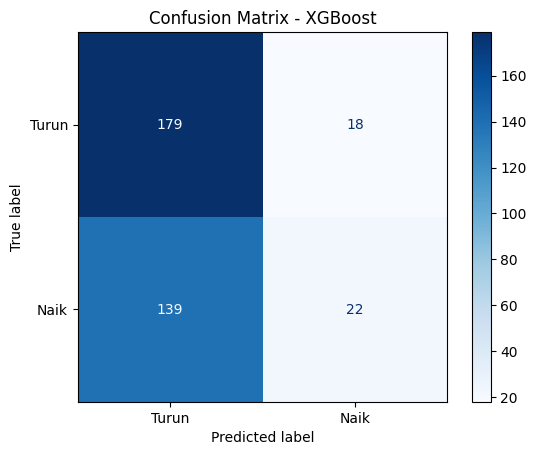

XGBoost Accuracy: 0.5614525139664804
XGBoost Precision: 0.55
XGBoost Recall: 0.13664596273291926


In [263]:
# Model XGBoost
model_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, Y_train)

# Prediksi dengan XGBoost
predictions_xgb = model_xgb.predict(X_valid)

# Evaluasi model XGBoost
print("XGBoost Classification Report:")
print(classification_report(Y_valid, predictions_xgb))

cm_xgb = confusion_matrix(Y_valid, predictions_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Turun', 'Naik'])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost')
plt.show()

print("XGBoost Accuracy:", accuracy_score(Y_valid, predictions_xgb))
print("XGBoost Precision:", precision_score(Y_valid, predictions_xgb))
print("XGBoost Recall:", recall_score(Y_valid, predictions_xgb))


#hasil Gambar Prediksi setiap klasifikasi

untuk melihat lebih jelasnya hasil dari prediksi setiap model, saya buatkan grafik pembanding antara model dengan dataset aslinya untuk melihat seperti apa keseusaiannya dalam memprediksi harga sahamnya

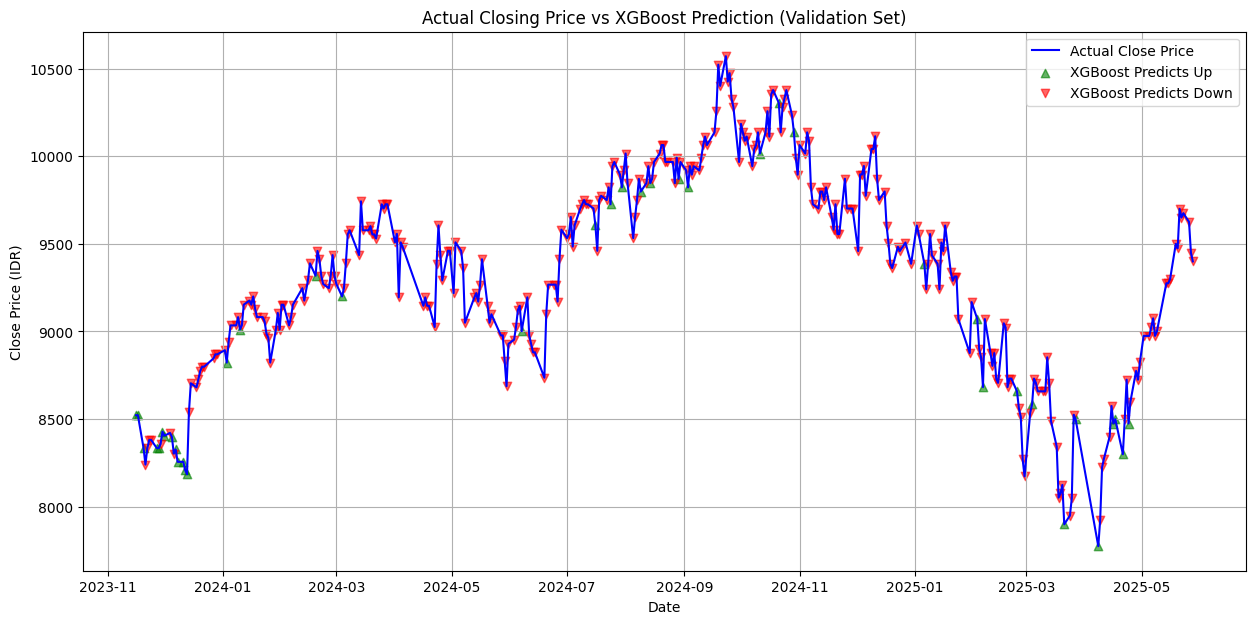

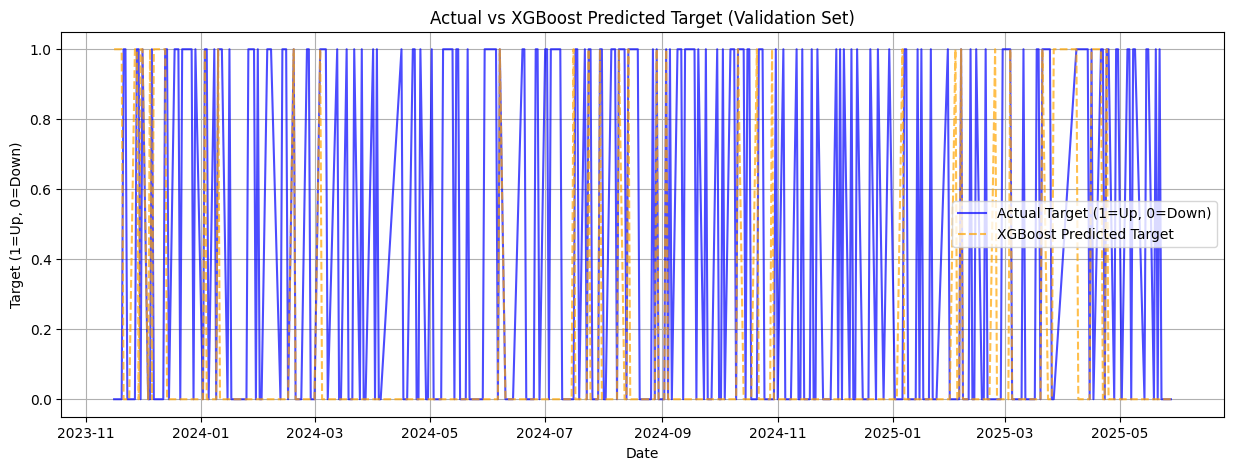

In [264]:
# Combine original data with predictions for visualization
df_valid = df.iloc[X_train.shape[0]:].copy() # Get the validation set from the original df
df_valid['Actual'] = Y_valid

# Make predictions using the trained model and assign them to the column
# The original code assigned the model object itself, causing the error.
df_valid['XGBoost_Predicted'] = model_xgb.predict(X_valid)

# Plot actual closing prices vs XGBoost predicted movement
plt.figure(figsize=(15, 7))

# Plot the actual closing price
plt.plot(df_valid.index, df_valid['Close'], label='Actual Close Price', color='blue')

# Highlight points where XGBoost predicts the price will go up (1) or down (0)
# We can color-code the actual close price points based on the prediction
up_preds = df_valid[df_valid['XGBoost_Predicted'] == 1]
down_preds = df_valid[df_valid['XGBoost_Predicted'] == 0]

plt.scatter(up_preds.index, up_preds['Close'], color='green', marker='^', alpha=0.6, label='XGBoost Predicts Up')
plt.scatter(down_preds.index, down_preds['Close'], color='red', marker='v', alpha=0.6, label='XGBoost Predicts Down')

plt.title('Actual Closing Price vs XGBoost Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# You can also plot the actual target vs predicted target directly on the validation set
plt.figure(figsize=(15, 5))
plt.plot(df_valid.index, df_valid['Actual'], label='Actual Target (1=Up, 0=Down)', color='blue', alpha=0.7)
plt.plot(df_valid.index, df_valid['XGBoost_Predicted'], label='XGBoost Predicted Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Actual vs XGBoost Predicted Target (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Target (1=Up, 0=Down)')
plt.legend()
plt.grid(True)
plt.show()

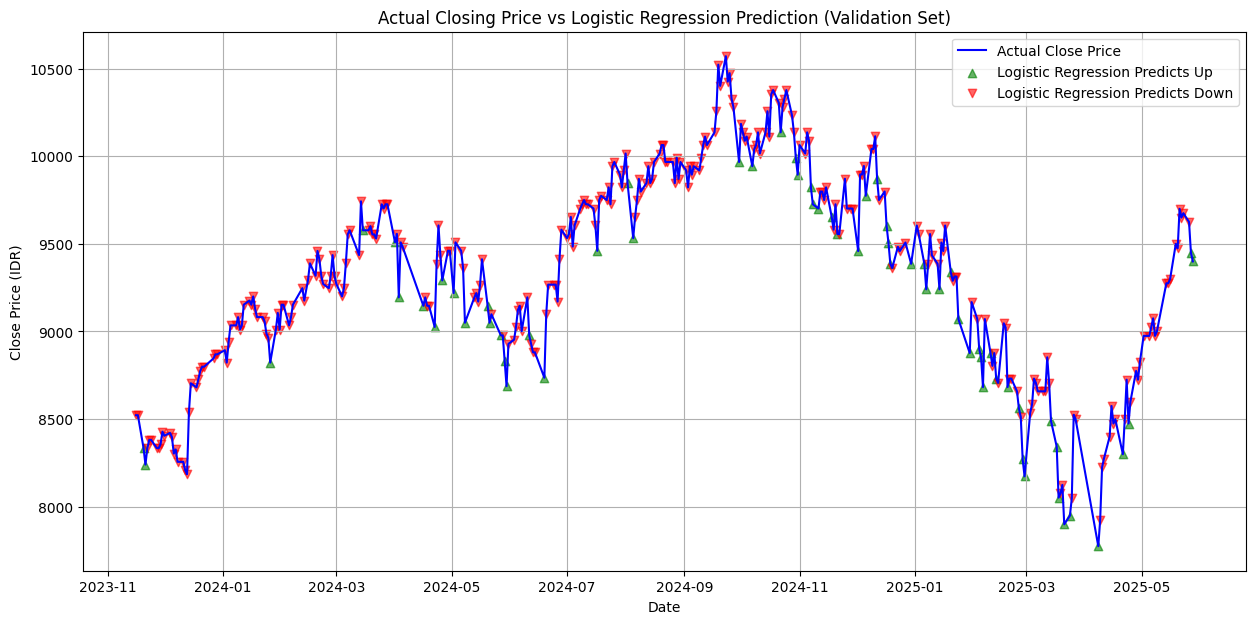

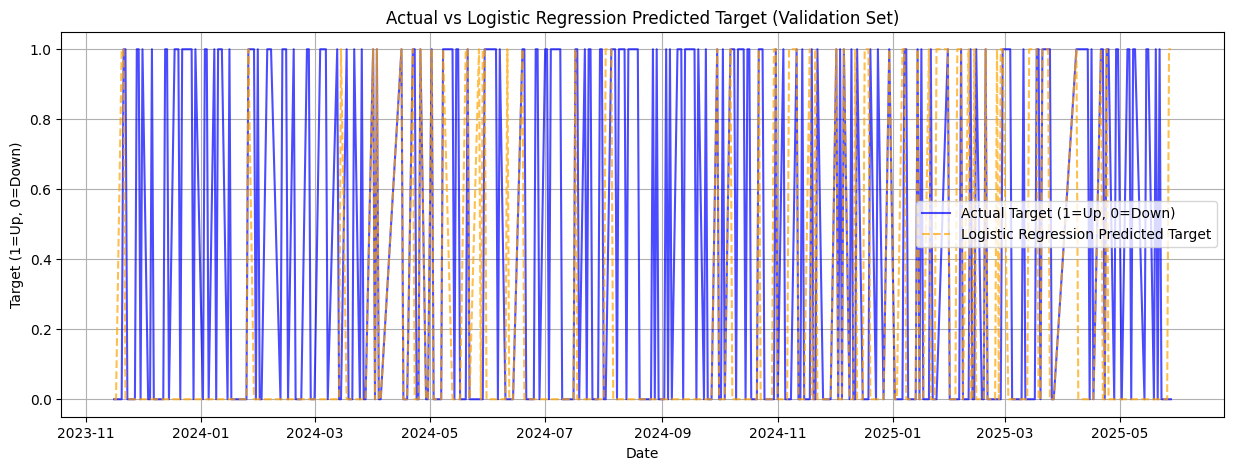

In [265]:
# Combine original data with predictions for visualization
df_valid = df.iloc[X_train.shape[0]:].copy() # Get the validation set from the original df
df_valid['Actual'] = Y_valid

# Make predictions using the trained model and assign them to the column
df_valid['LogisticRegression_Predicted'] = model_lr.predict(X_valid)

# Plot actual closing prices vs Logistic Regression predicted movement
plt.figure(figsize=(15, 7))

# Plot the actual closing price
plt.plot(df_valid.index, df_valid['Close'], label='Actual Close Price', color='blue')

# Highlight points where Logistic Regression predicts the price will go up (1) or down (0)
up_preds_lr = df_valid[df_valid['LogisticRegression_Predicted'] == 1]
down_preds_lr = df_valid[df_valid['LogisticRegression_Predicted'] == 0]

plt.scatter(up_preds_lr.index, up_preds_lr['Close'], color='green', marker='^', alpha=0.6, label='Logistic Regression Predicts Up')
plt.scatter(down_preds_lr.index, down_preds_lr['Close'], color='red', marker='v', alpha=0.6, label='Logistic Regression Predicts Down')

plt.title('Actual Closing Price vs Logistic Regression Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# You can also plot the actual target vs predicted target directly on the validation set
plt.figure(figsize=(15, 5))
plt.plot(df_valid.index, df_valid['Actual'], label='Actual Target (1=Up, 0=Down)', color='blue', alpha=0.7)
plt.plot(df_valid.index, df_valid['LogisticRegression_Predicted'], label='Logistic Regression Predicted Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Actual vs Logistic Regression Predicted Target (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Target (1=Up, 0=Down)')
plt.legend()
plt.grid(True)
plt.show()


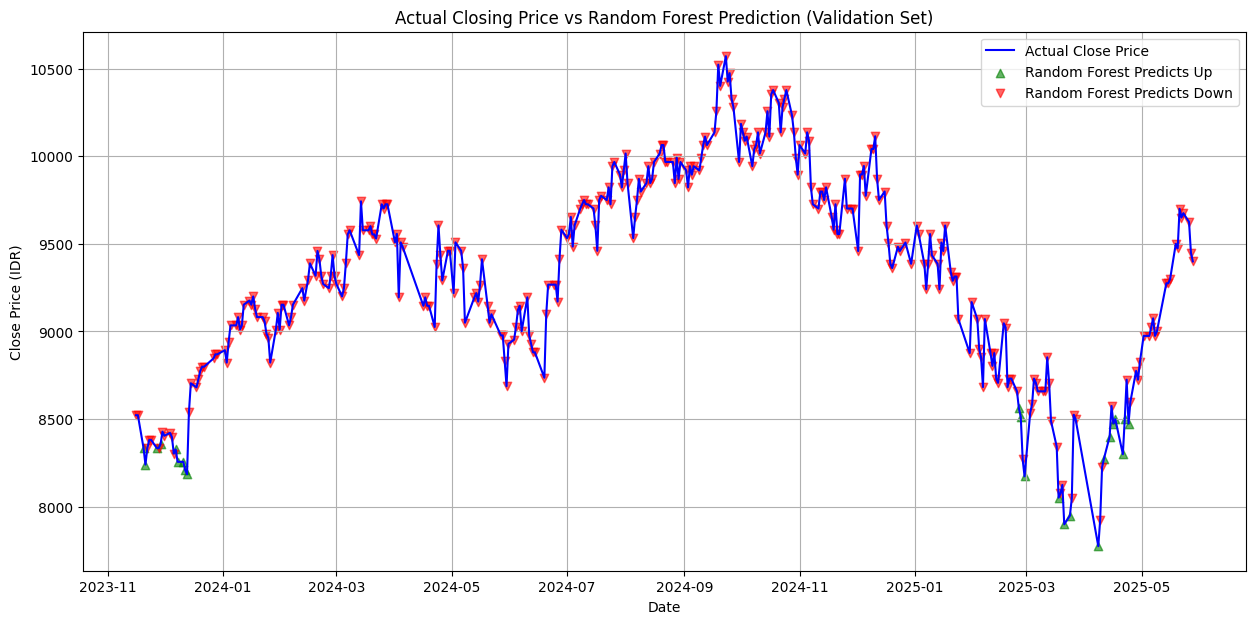

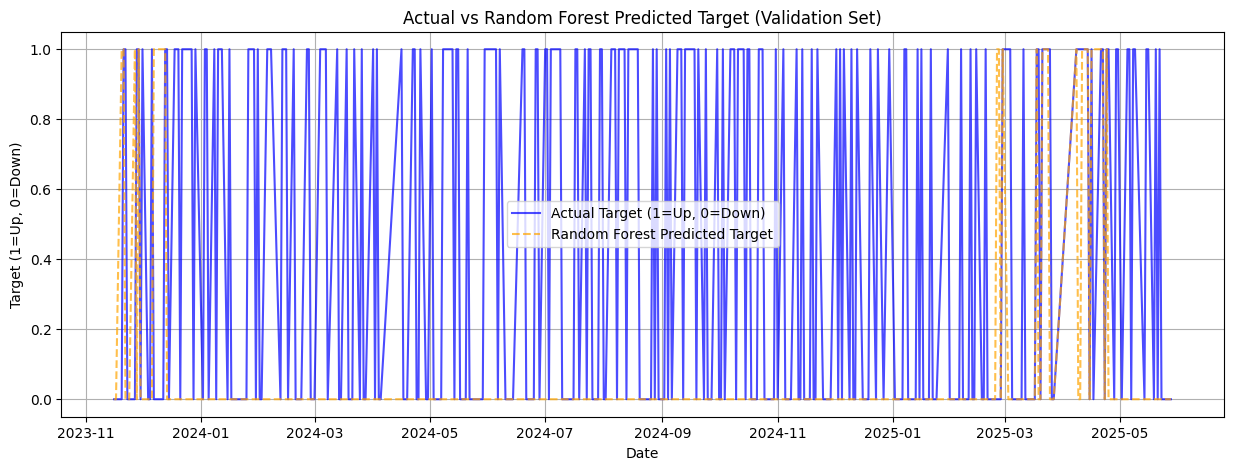

In [266]:
# Combine original data with predictions for visualization
df_valid = df.iloc[X_train.shape[0]:].copy() # Get the validation set from the original df
df_valid['Actual'] = Y_valid

# Make predictions using the trained model and assign them to the column
df_valid['RandomForest_Predicted'] = model_rf.predict(X_valid)

# Plot actual closing prices vs Random Forest predicted movement
plt.figure(figsize=(15, 7))

# Plot the actual closing price
plt.plot(df_valid.index, df_valid['Close'], label='Actual Close Price', color='blue')

# Highlight points where Random Forest predicts the price will go up (1) or down (0)
up_preds_rf = df_valid[df_valid['RandomForest_Predicted'] == 1]
down_preds_rf = df_valid[df_valid['RandomForest_Predicted'] == 0]

plt.scatter(up_preds_rf.index, up_preds_rf['Close'], color='green', marker='^', alpha=0.6, label='Random Forest Predicts Up')
plt.scatter(down_preds_rf.index, down_preds_rf['Close'], color='red', marker='v', alpha=0.6, label='Random Forest Predicts Down')

plt.title('Actual Closing Price vs Random Forest Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# You can also plot the actual target vs predicted target directly on the validation set
plt.figure(figsize=(15, 5))
plt.plot(df_valid.index, df_valid['Actual'], label='Actual Target (1=Up, 0=Down)', color='blue', alpha=0.7)
plt.plot(df_valid.index, df_valid['RandomForest_Predicted'], label='Random Forest Predicted Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Actual vs Random Forest Predicted Target (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Target (1=Up, 0=Down)')
plt.legend()
plt.grid(True)
plt.show()